# Fitting ensemble models with drfsc

## Load, fit, predict, and score using drfsc and WDBC example dataset
In this notebook we use the 
Breast Cancer Wisconsin (Diagnostic) Data Set (WDBC) dataset (available from UCI database at 'https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29') to demonstrate how to use the drfsc package and some of its functionality.

This example dataset is quite small, so only a small number of partitions will be used. This can be expanded arbitrarily, based on the dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.drfsc import *
from sklearn.model_selection import train_test_split


# loading data
We start by first loading the dataset available in 'data'

In [2]:
def load_wdbc(path):
    '''
    Takes given WDBC file and returns the data in a numpy array
    '''
    with open(path, "rb") as fo:
        data = np.loadtxt(
            fo, 
            delimiter = ",", 
            skiprows = 0, 
            converters = {1: lambda x: 1 if x.decode("utf-8") == "M" else 0}
        )
    return data

data = load_wdbc("data/wdbc/wdbc.data")
print(f"shape: {data.shape}, dimensions: {data.ndim}")


shape: (569, 32), dimensions: 2


As can be seen from the code below, the first column is an ID column (not used), the second column is the label, and the remaining columns are the features. We split the data accordingly.

In [3]:
data = pd.DataFrame(data)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302.0,1.0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517.0,1.0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903.0,1.0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301.0,1.0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402.0,1.0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
X = data.loc[:, 2:]
X.columns = [f"x_{i}" for i in range(1, X.shape[1] + 1)] # renaming columns
X.head()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_21,x_22,x_23,x_24,x_25,x_26,x_27,x_28,x_29,x_30
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
Y = data.loc[:, 1]
Y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: 1, dtype: float64

The data then needs to be split into training/validation/testing partitions for use by DRFSC. This is done in the standard way using scikit-learn's train_test_split function.

In [6]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42, stratify=Y_train)


To initialize our model, we call the DRFSC class. For this tutorial, we will use 10 iterations (n_runs), and 4 vertical and 2 horizontal partitions (n_vbins and n_hbins respectively). 

In this notebook we show the results for when output = 'ensemble'. This means that we return an ensemble based on the number of horizontal partitions (here n_hbins=2). The other option is 'single', which returns a single model based on information from all partitions.

In [7]:
model = DRFSC(n_vbins=4, n_hbins=2, n_runs = 10, output='ensemble', verbose = True)


DRFSC Initialised with parameters: 
             n_vbins = 4, 
             n_hbins = 2, 
             n_runs = 10, 
             redistribute = False, 
             sharing = all, 
             k = 0, 
             output = ensemble, 
             metric = roc_auc, 
             max_processes is 8 
 ------------


To load the data into the DRFSC model, we call the load_data function. This function preprocesses the data. Here, we can specify the degree of polynomial expansion desired (here we use degree=2 (polynomial)).

In [8]:
X_train, X_val, Y_train, Y_val, X_test, Y_test = model.load_data(X_train, X_val, Y_train, Y_val, X_test, Y_test, polynomial=2)

Information for Loaded Data: 
 -------------
'X_train' SHAPE: (364, 496)
          TYPE:  ndarray
'X_val'   SHAPE: (91, 496)
          TYPE:  ndarray
'Y_train' SHAPE: (364,)
          TYPE:  ndarray
'Y_val'   SHAPE: (91,)
          TYPE:  ndarray


To fit our DRFSC model, we simply call the fit() method and pass our training and validation data and labels. This will fit the model to the data and return the best model found.

In [9]:
model.fit(X_train, X_val, Y_train, Y_val)

Number of Samples: 364. Horizontal Disitribution SHAPE: (182, 2)
Number of Features: 496. Vertical Distribution SHAPE: (125, 4)
New best model for hbin 1. roc_auc=0.5 -- Model features [0]
New best model for hbin 0. roc_auc=0.95201 -- Model features [0, 351, 471]
New best model for hbin 0. roc_auc=0.95769 -- Model features [0, 164, 453]
New best model for hbin 1. roc_auc=0.94427 -- Model features [0, 357, 141]
New best model for hbin 0. roc_auc=0.97575 -- Model features [0, 83, 490]
New best model for hbin 1. roc_auc=0.9711 -- Model features [0, 57]
M: {0: {0, 164, 357, 453, 490, 83, 471, 351}, 1: {0, 57, 357, 141}}
M: {0: {0, 490, 83, 164}, 1: {0, 357, 141}}
New best model for hbin 1. roc_auc=0.97936 -- Model features [0, 357, 447]
New best model for hbin 0. roc_auc=0.97678 -- Model features [0, 83, 164]
M: {0: {0, 83, 164}, 1: {0, 357, 447}}
M: {0: {0, 83, 164}, 1: {0, 357, 141, 447}}
Iter 4. No appreciable improvement over the last 3 iterations in hbin 0
Iter 4. No appreciable impro

DRFSC(n_vbins=4, n_hbins=2, n_runs=10, redistribute_features=False, feature_sharing=all, k=0, output=ensemble, metric=roc_auc, verbose=True, polynomial=1, preprocess=True, max_processes=8)

Once a model has been fit, we can use it to predict labels using the predict_proba() or predict() methods. This function takes our test set data (X_test) as a sole argument, and returns the predicted probabilities and labels respectively.

In [10]:
y_pred = model.predict(X_test)
y_pred

array([0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1], dtype=int64)

In [11]:
y_prob = model.predict_proba(X_test)
y_prob

array([0.03039455, 1.        , 0.72762127, 0.99868181, 0.65637885,
       0.23431759, 0.99814245, 0.26257979, 0.05831337, 0.45186896,
       0.99998444, 0.02031319, 1.        , 0.17122291, 0.74851852,
       0.00527256, 0.98627681, 0.08947849, 0.72307366, 0.04657729,
       0.01106976, 0.40175246, 1.        , 0.99999998, 0.99933225,
       0.01753355, 0.01133478, 0.9999757 , 0.99999879, 1.        ,
       1.        , 0.38218214, 1.        , 1.        , 0.123072  ,
       0.59971195, 0.32686808, 0.01113845, 0.99991761, 0.97199921,
       0.05109432, 0.13049519, 0.99644305, 0.10375968, 0.48205988,
       0.99999934, 0.5407558 , 0.9999964 , 0.00250376, 0.24854396,
       1.        , 1.        , 0.3066338 , 0.10128072, 0.14676983,
       0.9999989 , 0.09320192, 0.00228128, 0.13720459, 1.        ,
       0.63596798, 0.76002978, 0.99961993, 0.00539441, 0.98583384,
       0.35555271, 0.99999999, 1.        , 0.54566794, 0.99974912,
       0.09290276, 1.        , 0.99999999, 0.02254776, 0.05358

Since n_hbins = 2, the number of models in our ensemble will be 2. To view the ensemble, we can call the model_ensemble attribute of our model. This returns dictionary that contains: the list of feature indices for the final model, the feature names (if they exist), and the resulting model object.

In [12]:
model.model_ensemble

{'model_h0': [[0, 83, 164],
  ['1', 'x_2 x_24', 'x_5 x_24'],
 'model_h1': [[0, 357, 447],
  ['1', 'x_14 x_28', 'x_21 x_27'],
  <statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x1cd92b82b20>]}

The `score` method combines the predictions from all models in the ensemble. However, if we wish to view the prediction probabilities of each of the model, we can access this by calling the `ensemble_pred` attribute

In [13]:
model.ensemble_pred

,model_h0,model_h1,mean_prob,majority
0,0.034050,0.026739,0.030395,0
1,1.000000,1.000000,1.000000,1
2,0.996220,0.459022,0.727621,1
3,0.998836,0.998527,0.998682,1
4,0.999718,0.313040,0.656379,1
...,...,...,...,...
109,0.013541,0.015376,0.014459,0
110,0.031329,0.014714,0.023021,0
111,0.981727,0.977242,0.979485,1
112,0.997891,0.998024,0.997957,1


# Model Evaluation

To find out how well our model performed, we can use the score() method. This method takes our test set data (X_test) and labels (Y_test) as arguments, and a metric as an optional argument (here we use the default metric, accuracy). It then calculates the metric on the test set, and returns the performance of the model on the test set.

In [14]:
model.score(X_test, Y_test)

{'metric': 'roc_auc', 'score': 0.9983465608465609}

# Model Visualization

To visualize the results, we can use the feature_importance(), pos_neg_prediction(), and single_prediction() methods. 

The feature_importance() method takes no arguments and displays the a histogram of the final model features and their coefficeints.

The pos_neg_prediction method takes as an argument the index of the sample we want to visualize. If we want to visualise a prediction on the test set, the test set should also be passed as an argument. This method displays the positive and negative predictions for the sample, computed by multiplying the data by the model coefficients and separating the positive and negative contributions.
- E.g. usage: pos_neg_prediction(0, X_test) for visualising the prediction on the first sample in the test set.

The single_prediction() method takes the same arguments as pos_neg_prediction(), and diplays the model coefficients weighted by the data for the sample. This is useful for visualising the model's prediction on a single sample.
- E.g. usage: single_prediction(0, X_test) for visualising the prediction on the first sample in the test set.

c:\Users\markc\Documents\Github\drfsc\src\drfsc.py:782: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  coef.loc['mean'] = coef.mean()


<BarContainer object of 5 artists>

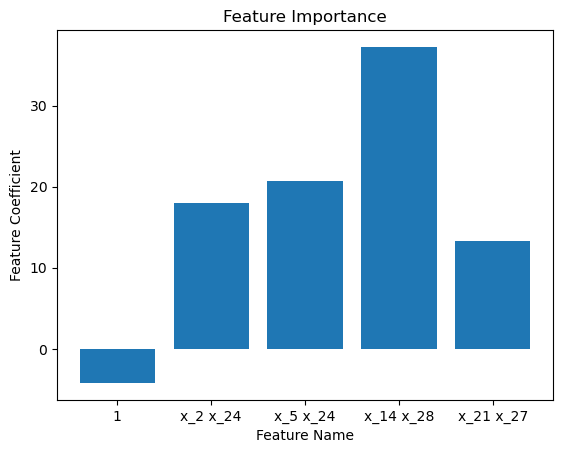

In [15]:
model.feature_importance()

<BarContainer object of 2 artists>

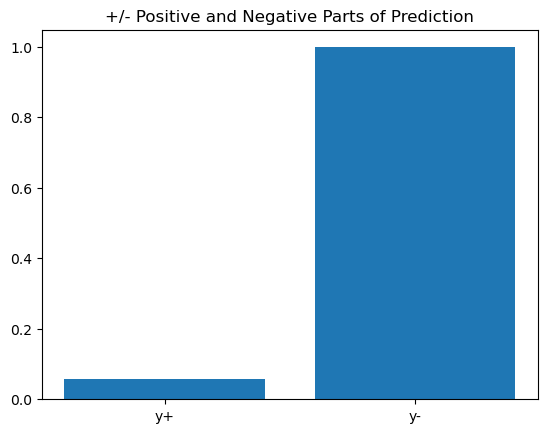

In [16]:
model.pos_neg_prediction(0, X_test)

<BarContainer object of 5 artists>

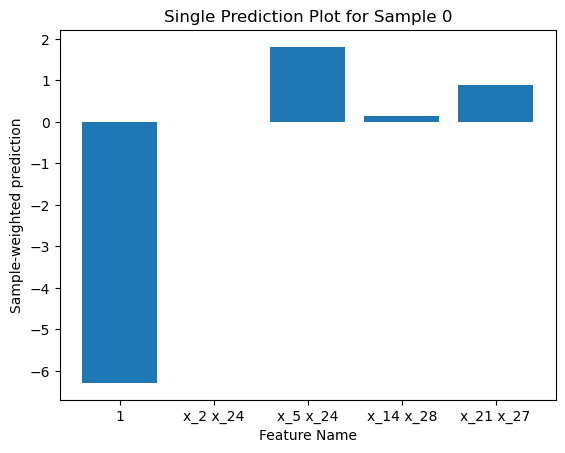

In [17]:
model.single_prediction(0, X_test)

<BarContainer object of 5 artists>

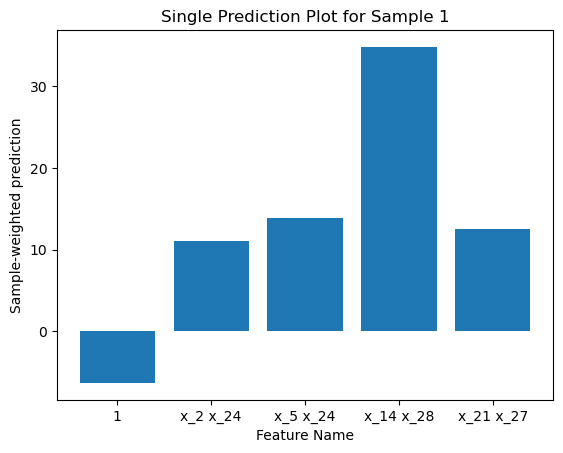

In [22]:
model.single_prediction(1, X_test)